In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

#random choice
import random

from scipy.constants import k

In [2]:
import matplotlib as mpl

mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

# The Ising model in 2D
The Hamiltonian of the Ising model is

$$
\mathcal{H} = -\sum_{\langle ij \rangle} J s_i s_j - H \sum_i s_i
$$

In this exercise, we focus on the case $J=1, H=0$, that is, a ferromagnetic system with no external field. Remember that the sum $\langle ij \rangle$ runs over neighbouring sites only. In our 2D lattice, each site has 4 neighbours. 

<img src="images/4.1.png" width="250"> 


We will work with **periodic boundary conditions**, so that all spins have 4 neighbours. 

<img src="images/4.2.png" width="250"> 


# The Metropolis algorithm
We will build a simple implementation of the **Metropolis** algorithm for the 2D Ising model. 

As a reminder, a single update of the Metropolis algorithm works as follows:

1. Pick a site $(i, j)$ at random.
2. Calculate the energy change $\Delta E$ that flipping the spin $s_{ij}$ would produce.
3. If $\Delta E <0$, flip the spin with probability $1$.
4. If $\Delta E >0$, flip the spin with probability $e^{-\beta \Delta E}$.

### Exercice 4.1
Write a function that, given an integer $N$, returns an $N \times N$ array whose elements are randomly picked from {-1, 1}. 

In [3]:
def create_initial_config(N=None):
    """
    Create the starting initial configuration.
    
    All elements are {-1, 1} with 50% prob.
    The lattice is a square of size N.
    
    Parameters
    ----------
    N : int
        The system size.

    Returns
    -------
    config : np.array, (N, N)
        A random {-1, 1} array of size (N, N).
    """
    seq = [-1,1]
    config = np.ndarray(shape=(N,N), dtype = int)
    for i in range(0,N):
        for j in range(0,N):
            config[i][j] = random.choice(seq)

    return config

Let us create an initail configuration with our `create_inital_config_function`. A system size of $N=100$ will be enough.

In [4]:
%%time
config = create_initial_config(N=100)

CPU times: user 5.05 ms, sys: 124 µs, total: 5.18 ms
Wall time: 16.1 ms


To plot our system we can use `plt.imshow()`, as follows:

CPU times: user 19.3 ms, sys: 19.3 ms, total: 38.6 ms
Wall time: 28.4 ms


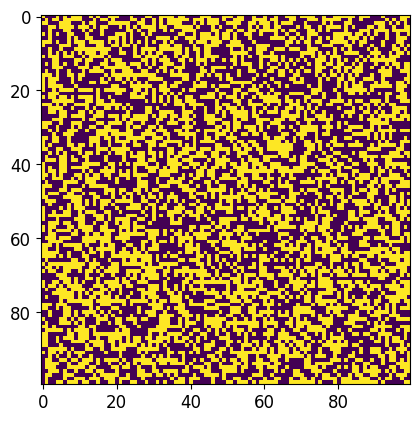

In [5]:
%%time
plt.imshow(config);

### Exercise 4.2
We will write our Metropolis update function. Given a site $(i, j)$, what is the change in energy $\Delta E$ that flipping $S(i, j)$ entails?
Recall that only 4 spins are connected to $(i, j)$, so you don't need to compute the energy of the whole system.

La variazione di energia dovuta al cambiamento di $S_{i, j}$ è:

$\Delta E_{ij}=\Delta(-J S_{i, j} S_{i, j-1} - J S_{i, j} S_{i, j+1} - J S_{i, j} S_{i-1, j} - J S_{i, j} S_{i+1, j}) = -J\Delta(S_{i, j}M_{i, j}) = -J M_{i, j} \Delta(S_{i, j}) = 2 J M_{i, j} S_{i, j}$

con

$M_{i, j}= S_{i, j-1} + S_{i, j+1} + S_{i-1, j} + S_{i+1, j}$

### Exercise 4.3
Write a function called `metropolis_single_update()`.  
The **input** should be:

+ *config*, a lattice configuration as an (N, N) array.
+ *T*, the temperatue.

There is no need to return anything since in python, functions can modify its input, so we will be updating config *inplace*. But it is useful to return the energy change $\Delta E$ if one later wants to track the energy during simulations. To simplify things, we will use **periodic boundary conditions** (in python, the modulo operator is `%`).

In [6]:
def get_near_coordinates(dim=None, i=None, j=None):
    connected_coordinates = np.array([
        [ i, (j + 1) % dim ],
        [ i, (j - 1) % dim ],
        [ (i + 1) % dim, j ],
        [ (i - 1) % dim, j ]
        ] )
    
    return connected_coordinates

In [7]:
def sum_near(config=None, i=None, j=None):
    N = config.shape[0]
    
    sum = 0
    connected_coordinates = get_near_coordinates(N,i,j)
    for i in range (0, connected_coordinates.shape[0]):
        sum += config[connected_coordinates[i,0], connected_coordinates[i,1]]
        
    return sum

In [8]:
def metropolis_single_update(config=None, T=None):
    '''
    Do a single Monte Carlo update using Metropolis algorithm.
    
    Parameters
    ----------
    config : np.array, (N, N)
        The current configuration.
    T : float
        The temperature.

    '''
    # make sure config is square
    N, M = config.shape
    assert N==M
    
    # choose random site
    i = random.randint(0,N-1)
    j = random.randint(0,N-1)
    s = config[i, j]
        
    # compute energy cost of flip
    # DeltaE is the possible energy cost
    # effDeltaE is the real energy cost (depending on whether we did the flip or not)
    DeltaE = 2*s * sum_near(config,i,j)
    effDeltaE = 0

    # case DeltaE < 0, flip the spin with prob 1 
    if DeltaE < 0:
        # flip the spin
        s *= -1
        # set effective DeltaE to DeltaE 
        effDeltaE = DeltaE
        
    # case DeltaE >= 0
    else:
        # flip the spin with certain probability
        if random.random() < np.exp(-(DeltaE)/(k * T)):
            # flip the spin
            s *= -1
            # set effective Delta E 
            effDeltaE = DeltaE
        
    # update configuration
    # notice there is no need to return the whole configuration, the function
    # will modify config _in_place_
    config[i, j] = s
    
    # but it is clever to return the effective DeltaE, since we have already computed it
    # notice that if we didn't flip the spin, the change in energy is 0
    return effDeltaE

## Visualizing the simulation on real time
To see if our Metropolis algorithm works, you might want to simulate systems at different temperatures, and observe how the configuration evolves trought time. To do this you need the `display` module. Below you will find an example of how to use it.

For the 2D Ising model, the **critical temperature** is known to be
$$
T_c = \frac{2}{\ln(1+\sqrt{2})} \simeq 2.2691853...
$$
(with $k_B=1$). Try executing the cell below at different values of the temperature, for different system size. 

CPU times: user 5.29 s, sys: 1.24 s, total: 6.54 s
Wall time: 6.45 s


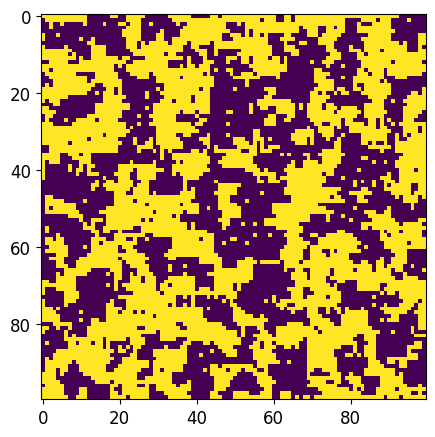

In [9]:
%%time
T_c = 2/np.log(1+np.sqrt(2))
k=1 #costante di Boltzmann=1

# create initial random configuration
config = create_initial_config(N=100)

# set up figure, plot first frame
fig, ax = plt.subplots(1, 1, figsize=(6,5))
# draw the initial configuration,
# naming the plot "im".
im = ax.imshow(config)

for t in range(100000):
    # update the system
    DeltaE = metropolis_single_update(config, T=T_c)
    # replot every 1000 MC updates
    if t%1000==0:
        # update the data of the plot (not the whole figure!)
        im.set_data(config)
        # rerender
        display.display(plt.gcf())
        display.clear_output(wait=True)

### Exercice 4.4
Write a function that computes the energy of a configuration, and another that tracks its evolution over time.

In [10]:
def get_energy(config):
    """
    Compute the energy of a configuration.
    
    The energy is defined as $E = -\sum_{(a, b)} S_a S_b$,    
    where the sum runs over pairs of adjacent spins.
    
    Parameters
    ----------
    config : np.array, (N, N)
        The system configuration.
        
        
    Returns
    -------
    E : float
        The energy of the configuration.
    """
    N = len(config)
    # list of pairs of adjacent sites as four-element tuples:
    # (i1, j1, i2, j2) represents two adjacent sites located
    # at (i1, j1) and (i2, j2)
    horizontal_edges = [
        (i, (j-1) % N, i, (j+1) % N)
        for i in range(N) for j in range(N)
    ]
    vertical_edges = [
        ((i-1)%N, j, (i+1)%N, j)
        for i in range(N) for j in range(N)
    ]
    # summing lists in python concatenates them
    # [1, 2, 3] + [4, 5] = [1, 2, 3, 4, 5]
    edges = horizontal_edges + vertical_edges
    E = 0
    for i1, j1, i2, j2 in edges:
        E -= config[i1,j1] * config[i2,j2]
    
    return E

In [11]:
def get_energy_evolution(N=20, T=T_c, n_updates=50000):
    """
    Compute the energy evolution of a 2D Ising instance.
    
    Parameters
    ----------
    N : int
        The system size.
    T : float
        The temperature.
    n_updates : int
        Number of Metropolis updates.
        
    Returns
    -------
    Es : np.array, (n_updates, )
    """
    
    config = create_initial_config(N)
    Es = np.ndarray(shape=(n_updates), dtype=float)
    Es[0]=get_energy(config)
    for i in range(1, n_updates):
        Es[i] = Es[i-1] + metropolis_single_update(config, T)
    
    return Es

### Exercise 4.5
Compute the energy of your system during a long simulation, and plot it as a function of time. **Tip** Use logarithmic x-axis!

In [12]:
%%time
steps=10**5
times=range(steps)
temperature=[T_c/2, T_c, 2*T_c]
energy = np.array([get_energy_evolution(N=100, T=T, n_updates=steps)
                   for T in temperature])

CPU times: user 1.07 s, sys: 340 ms, total: 1.41 s
Wall time: 1.42 s


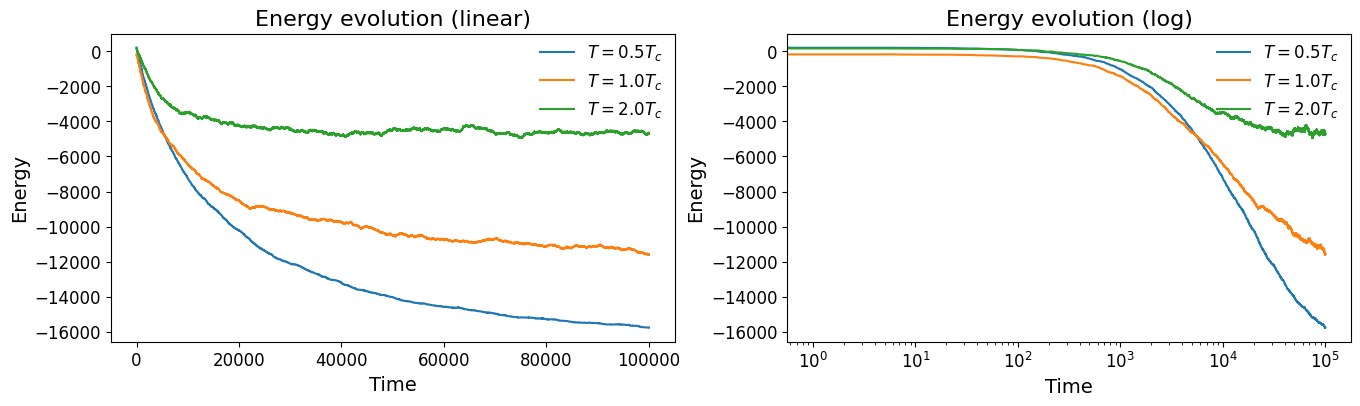

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

for i in range(len(temperature)):
    #lineare
    ax1.plot(times, energy[i], label=f"$T={temperature[i]/T_c}T_c$")
    #logaritmico
    ax2.semilogx(times, energy[i], label=f"$T={temperature[i]/T_c}T_c$")

#plot lineare
ax1.set_title("Energy evolution (linear)")
ax1.set_xlabel("Time")
ax1.set_ylabel("Energy")
ax1.legend(loc=(0.75, 0.7), frameon=False)

#plot logaritmico
ax2.set_title("Energy evolution (log)")
ax2.set_xlabel("Time")
ax2.set_ylabel("Energy")
ax2.legend(loc=(0.75, 0.7), frameon=False)

### Exercise 4.6
Can you distinguish two qualitatively different periods? What do they correspond to?

Si distinguono due periodi qualitativamente differenti.

Nel primo periodo l'energia cala rapidamente: ciò piò essere attribuito al fatto che il nostro algoritmo favorisce quelle trasformazioni che portano a un calo dell'energia.

Nel secondo periodo si osserva che, a meno di fluttuazioni casuali, l'energia resta costante nel tempo. Il motivo è che in questa fase, pur essendo vero che le trasformazioni che abbassano l'energia sono favorite dall'algoritmo, queste trasformazioni sono molto rare. Qesto perchè il sistema ha ormai raggiunto i livelli più bassi di energia; è quindi poco probabile estrarre una trasformazione casuale che provochi un calo dell'energia.

In effetti possiamo affermare che il sistema raggiunge l'equilibrio quando la probabilità che l'energia salga eguaglia quella che l'energia scenda, ovvero che la probabilità di estrarre casualmente una trasformazione che abbassi l'energia eguaglia la probabilità di estrarre (e accettare) una trasformazione che aumenti l'energia.

# Efficient Metropolis
Our implementation of the Ising model was not very efficient. To do this exercice, we will use part of the code from Sethna's book, which is much more efficient and can be found here:

[Sethan's book computer exercices](http://pages.physics.cornell.edu/~myers/teaching/ComputationalMethods/ComputerExercises/Ising/Ising.html)

To import code from an external file, we need to add its directory to the PATH



In [14]:
import sys
sys.path.append("code/")
from ising_sethna import IsingModel

Their implementation is based on a `Class`, which means we need to instantiate the model. For instance:

In [15]:
%%time
# create an instance of IsingModel
ising = IsingModel(N=100)

CPU times: user 2.86 ms, sys: 9.49 ms, total: 12.3 ms
Wall time: 19.5 ms


In [16]:
# the state of the system is stored in .lattice
ising.lattice

array([[1, 1, 0, ..., 1, 0, 1],
       [1, 1, 1, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 1, 1],
       [0, 1, 1, ..., 1, 0, 1]])

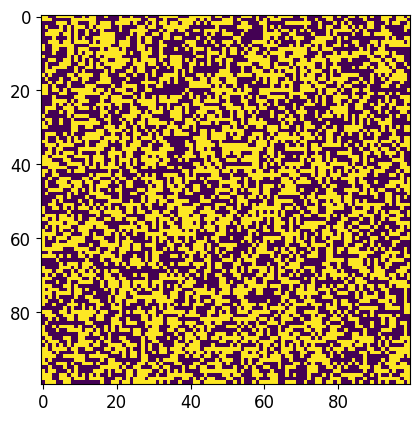

In [17]:
mpl.rcParams['axes.spines.right'] = True
mpl.rcParams['axes.spines.top'] = True
plt.imshow(ising.lattice)

Notice that this implementation uses 0, 1 spins instead of -1, 1 as we are used to! To run the simulation, we call the `.SweepMetropolis()` method. If you go to the source file at `SethnasBookCode/Ising.py`, you can inspect all the code. You will notice that all `.Sweep...()` methods perform $N^2$ updates per time-step. This is useful because time-scales become independent of system size.

In [18]:
%%time
ising.SweepMetropolis(nTimes=1000)

CPU times: user 13.9 s, sys: 0 ns, total: 13.9 s
Wall time: 13.9 s


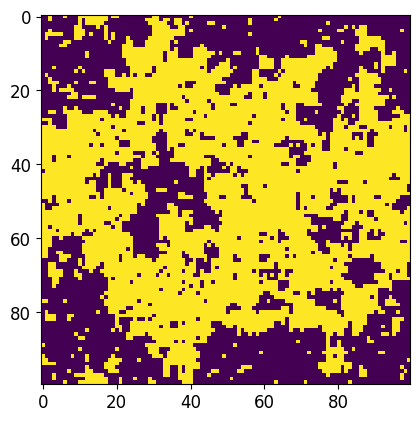

In [19]:
plt.imshow(ising.lattice)

The cell bellow will display 3 systems side-by-side, running at different temperatures. All parameters are set at the top. Try changing some values and see what happens.

In [20]:
#################
# set parameters
system_size = 100
H = 0.0
T_below = 1.5
T_critical = 2/np.log(1+np.sqrt(2))
T_above = 3.5
n_sweeps = 100
###############

# create three instances of IsingModel
ising_below = IsingModel(N=system_size, T=T_below, H=H)
ising_critical = IsingModel(N=system_size, T=T_critical, H=H)
ising_above = IsingModel(N=system_size, T=T_above, H=H)

# give them names
isings = [ising_below, ising_critical, ising_above]
labels = ["below $T_c$", "at $T_c$", "above $T_c$"]

CPU times: user 20.5 s, sys: 346 ms, total: 20.8 s
Wall time: 20.8 s


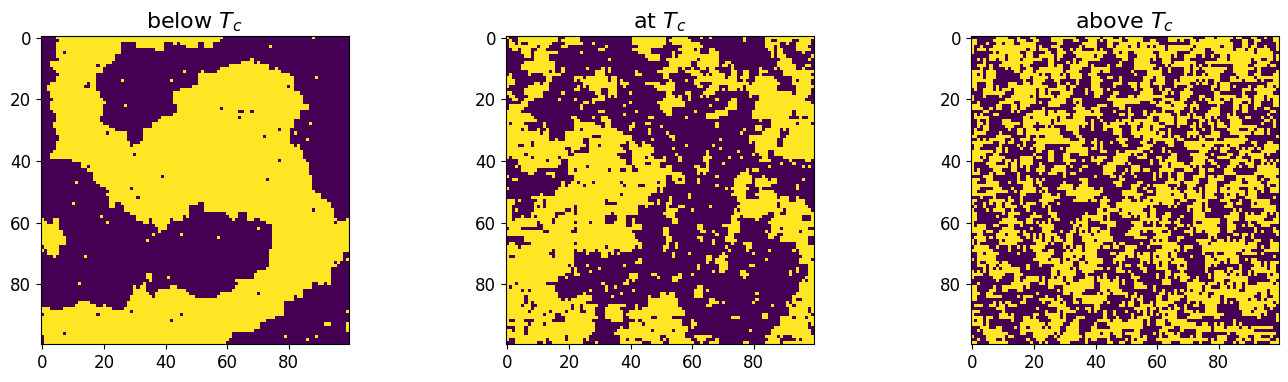

In [21]:
%%time
fig, axx = plt.subplots(1, 3, figsize=(17,4))
heatmap = {}
for ax, ising, label in zip(axx, isings, labels):
    heatmap[label] = ax.imshow(ising.lattice)
    ax.set_title(label, fontsize=16)

for _ in range(n_sweeps):
    for ax, ising, label in zip(axx, isings, labels):
        ising.SweepMetropolis(nTimes=1)
        heatmap[label].set_data(ising.lattice)
    display.display(plt.gcf())
    display.clear_output(wait=True)

### Exercice 4.7
How much faster is Sethna's implementation with respect to ours? Use the cell magic `%%timeit` to measure how long a command takes to execute.

To do a fair comparison, remember to take into account what "one update" means for each case.

In [22]:
#creo una funzione che chiama N*N volte metropolis_single_update(), per portarsi allo stesso livello di SweepMetropolis()
def mySweepMetropolis(config, T):
    """
    Esegue N_N trasformazioni Metropolis.
    Restituisce la variazione di energia.
    """
    N = len(config)
    deltaE = 0
    for i in range(N*N):
        deltaE += metropolis_single_update(config, T)
    
    return deltaE

In [23]:
#parametri delle simulazinoi
N=10
temperature=[T_c/2, T_c, T_c*2]
cicli=10

In [24]:
%%timeit
# your Ising implementation running for some number of updates

for T in temperature:
    #condizione iniziale
    config=create_initial_config(N)
    #faccio evolvere il sistema
    for i in range(cicli):
        mySweepMetropolis(config, T)

15.7 ms ± 1.23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [25]:
%%timeit
# Sethna's implementation running for some **equivalent** number of updates

for T in temperature:
    #condizione iniziale
    ising=IsingModel(N=N, T=T, H=0)
    #faccio evolvere il sistema
    for i in range(cicli):
        ising.SweepMetropolis(nTimes=1)

5.44 ms ± 347 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Magnetization
We will now compute the magnetization $M$ as a function of the temperature $T$. To speed up simulations even more, we will use the Wolff algorithm, which Sethna's code already implements in the `.SweepWolff()` method.

### Exercise 4.8
For a system of size $N=100$, approximately how many sweeps of the Wolff algorithm are necessary in practice to be in equilibrium? Try starting with smaller values of $N$, and increase gradually. 

In [26]:
def get_energy_sethna(config):
    
    N = len(config)
    #list of pairs of adjacent sites as four-element tuples:
    #(i1, j1, i2, j2) represents two adjacent sites located
    # at (i1, j1) and (i2, j2)
    horizontal_edges = [
        (i, j, i, (j+1)%N)
        for i in range(N) for j in range(N)
    ]
    
    vertical_edges = [
        (i, j, (i+1)%N, j)
        for i in range(N) for j in range(N)
    ]
    
    #summing lists in python concatenates them
    # [1, 2, 3] + [4, 5] = [1, 2, 3, 4, 5]
    edges = horizontal_edges + vertical_edges
    E = 0
    
    for i1, j1, i2, j2 in edges:
        E -= 4*config[i1, j1]*config[i2, j2] + 1 - 2 * (config[i1, j1] + config[i2, j2])
        
    return E

In [27]:
%%time

# set system size, temperature
N = 100
T = T_c

# initialize model
model = IsingModel(N=N, T=T, H=0)
energy_m = np.zeros(N+1)
energy_m[0] = get_energy_sethna(model.lattice)

# run some Wolff sweeps, check if equilibrium
for i in range(1, N+1, 1):
    model.SweepWolff(nTimes=1, partialSweep=0)
    energy_m[i] = get_energy_sethna(model.lattice)

CPU times: user 3.63 s, sys: 17.4 ms, total: 3.65 s
Wall time: 3.65 s


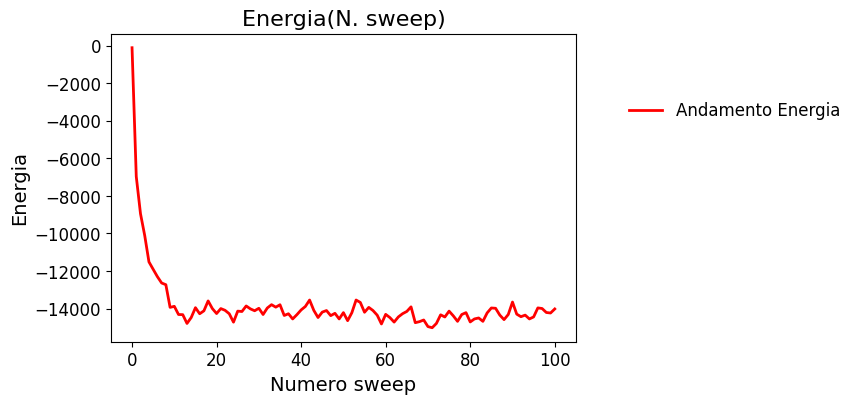

In [28]:
#grafico per equilibrio
x = np.array([
    t
    for t in range(0, N+1, 1)
])

fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.plot(
    x, energy_m,
    color = "red",
    lw = 2,
    label = "Andamento Energia",
)

ax.set_title("Energia(N. sweep)")
ax.set_xlabel("Numero sweep")
ax.set_ylabel("Energia")
ax.legend(loc=(1.1, 0.7), frameon=False)

Si osserva graficamente che dopo circa 20 sweep si raggiunge l'equilibrio

### Exercise 4.9
Write a function that computes the magnetization of a 2D Ising system after certain equilibration period.

In [29]:
def calculate_magnetization(system_size=None, temperature=None, equilibration_time=None):
    """
    Calculate the magnetization of a 2D Ising model.
    
    Parameters
    ----------
    system_size : int
        The lattice size.
    temperature : float
        The simulation temperature.
    equilibration_time : int
        Number of Wolff sweeps before measuring M.
        
    """
    # instantiate model
    model = IsingModel(system_size, temperature, H=0)
    # equilibrate
    for i in range(equilibration_time):
        model.SweepWolff()
    # compute magnetization
    m = (2*model.lattice.sum()) - (system_size**2)

    return m

### Exercise 4.10
+ Compute the magnetization for a system of size $N=64$, for diverent values of $T\in[1.5, 3.5]$.
+ Remember to choose wisely the equilibration time!
+ Plot $|M|$ as a function of $T$, and mark the critical temperature in your plot using the `plt.axvline()` function.

In [30]:
%%time
# define range of temperatures
temperatures = np.linspace(1.5, 3.5, num=200)
# system size
system_size = 64
# equilibration time
equilibration_time = 20

# loop over temperatures, compute magnetizations
magnetizations = []
for temperature in temperatures:
    magnetization = np.abs(calculate_magnetization(system_size, temperature, equilibration_time))
    magnetizations.append(magnetization)

CPU times: user 38.5 s, sys: 176 ms, total: 38.7 s
Wall time: 38.9 s


Text(0, 0.5, 'Magnetizzazione')

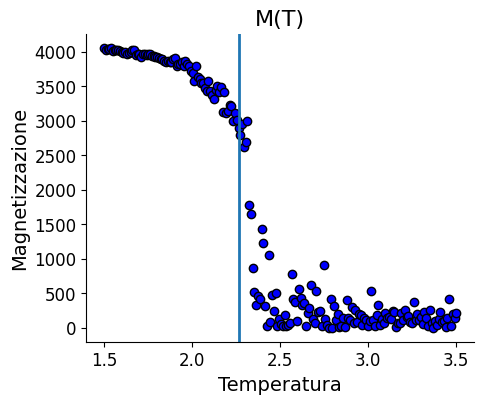

In [31]:
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.scatter(
    temperatures, magnetizations,
    # style keywords
    edgecolors="black", color="blue"
)
ax.axvline(
    T_c,
    # style keywords
    lw=2
)
ax.set_title("M(T)")
ax.set_xlabel("Temperatura")
ax.set_ylabel("Magnetizzazione")

## Susceptibility and Specific Heat


In this exercice, we will compute the susceptibility $\chi$ and the specific heat $C$. Using formula (6.13) in the book, we have that
$$
C = \frac{1}{T^2} \left\langle (E - \langle E \rangle)^2 \right\rangle.
$$
Remember that this is only valid in **equilibrium**, which means that we can only measure energy fluctuations **after a transient** equilibration time.

### Exercise 4.11
Find a convenient formula to measure the susceptibility $\chi$ in a simulation.

Sia $M$ la magnetizzazione di un sistema con $N$ spin:
$$
M=\frac{1}{N} \sum_{i}s_i
$$
L'energia del sistema è data dall'hamiltoniana del modello di Ising:
$$
E=-J\sum_{<i, j>}s_i s_j -H \sum_{i} s_i = -J\sum_{<i, j>}s_i s_j -NHM
$$
essendo $H$ il campo magnetico esterno e $J$ una costante di scarsa rilevanza ai nostri fini.

Per definizione la suscettività magnetica del sistema è
$$
\chi=\frac{\partial \langle M \rangle}{\partial H}
$$
e può essere ricavata calcolando la derivata, sostituendo $\langle M \rangle = \frac{1}{z} \sum_s M_s e^{-\beta E_s}$ (essendo $z$ la funzione di partizione) e tenendo conto che $\frac{\partial E}{\partial H} = -NM$

Eseguando i calcoli si ottiene
$$
\chi = \beta N \big(\langle M^2 \rangle - \langle M \rangle^2 \big) = \frac{N}{K_B T} {\sigma_M}^2
$$
Ovvero che la suscettività magnetica è proporzionale alla varianza della magnetizzazione.

### Exercise 4.12
Write a function that computes the energy of an Ising configuration.

As usually, you can use the **template** below if it helps you, or if you prefer you can also write **your own function** from scratch.

In [32]:
def compute_energy(ising):
    """Compute the energy of an ising object."""
    
    config = ising*2-1
    N = len(config)
    
    horizontal_edges = [
        (i, j, i, (j+1)%N)
        for i in range(N) for j in range(N)
    ]
    
    vertical_edges = [
        (i, j, (i+1)%N, j)
        for i in range(N) for j in range(N)
    ]

    edges = horizontal_edges + vertical_edges
    
    E = 0
    
    for i1, j1, i2, j2 in edges:
        E -= config[i1,j1] * config[i2,j2]
        
    return E / N**2

### Exercise 4.13
Write a function that computes the susceptibility and the specific heat of a 2D Ising system. You might use the Wolff algorithm to speed up your simulations.

In [33]:
def calculate_magnetization_2(ising):
    
    config = ising*2-1
    N = len(config)
    m = 0
    
    for r in range(0,N):
        for c in range(0,N):
            m += config[r,c]
            
    return np.abs(m/N**2)

In [34]:
def calculate_susceptibility_specific_heat(system_size=None, temperature=None, equilibration_time=None, n_samples=None):
    """
    Simulate a 2D Ising model and measure its
    specific heat and susceptibility at equilibrium.
    
    Parameters
    ----------
    system_size : int
        The lattice side length.
    temperature :  float.
        The simulation temeperature.
    equilibration_time : int
        A transient period to allow for thermalization.
    n_samples : int
        The number of samples taken to compute fluctuations.

    """
    # initialize model
    model = IsingModel(N=system_size, T=temperature, H=0)
    
    # thermalize
    for i in range(equilibration_time):
        model.SweepWolff()
    
    # create empty lists for magnetizations, energies, and their squares
    ms = []
    m2s = []
    es = []
    e2s = []
    
    # loop over n_samples 
    for _ in range(n_samples):
        # update system
        model.SweepWolff()
        # get magnetization
        m = calculate_magnetization_2(model.lattice)
        ms.append(m)
        m2s.append(m**2)
        # get energy
        e = compute_energy(model.lattice)
        es.append(e)
        e2s.append(e**2)
        
    
    # compute susceptibility and specific heat
    susceptibility = (system_size**2) * (1)/(temperature) * (np.average(m2s) - ((np.average(ms))**2))
    specific_heat = (1)/(temperature**2) * (np.average(e2s) - ((np.average(es))**2))
    
    return susceptibility, specific_heat

### Exercise 4.14
+ Compute $C$ and $\chi$ at different temperatures, for a small system of size $N<50$. You will need to find what are the right equilibration times. A good range of temperatures is $T \in [1.5, 3.5]$.
+ Make two plots, showing $\chi$ and $C$ as a function of $T$. Mark the critical temperature $T_c$ with a vertical line using `ax.axvline(...)`.

In [35]:
%%time
# define range of temperatures: 50 points from 1.5 to 4.
temperatures = np.linspace(1.5, 4, num=50)
# system size
system_size = 30
# equilibration time
equilibration_time = 20
# n_samples
n_samples = 1500

# loop over temperatures, compute susceptibility and specific_heat  
susceptibility = []
specific_heat = []
for temperature in temperatures:
    susceptibility_i, specific_heat_i = calculate_susceptibility_specific_heat(system_size, temperature, equilibration_time, n_samples)
    susceptibility.append(susceptibility_i)
    specific_heat.append(specific_heat_i)

CPU times: user 3min 10s, sys: 49.1 ms, total: 3min 10s
Wall time: 3min 11s


Text(0.5, 1.0, 'specific_heat(T)')

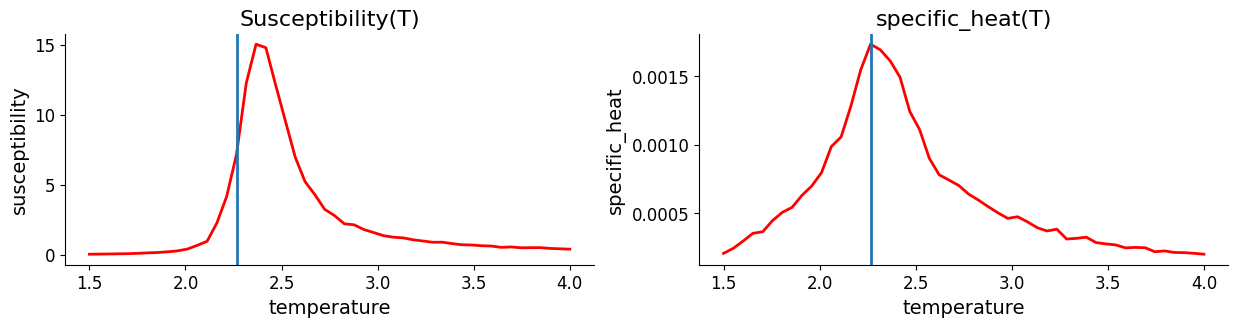

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,3))

ax=ax1
ax.plot(
    temperatures, susceptibility,
    color = "red",
    lw = 2,
    label = "Susceptibility",
)

ax.axvline(
    T_c,
    # style keywords
    lw=2,
)
    
ax.set_ylabel("susceptibility")
ax.set_xlabel("temperature")
ax.set_title("Susceptibility(T)")

ax=ax2

ax.plot(
    temperatures, specific_heat,
    color = "red",
    lw = 2,
    label = "Susceptibility",
)

ax.axvline(
    T_c,
    # style keywords
    lw=2,
)

ax.set_ylabel("specific_heat")
ax.set_xlabel("temperature")
ax.set_title("specific_heat(T)")


### Exercise 4.15
Discuss whether or not your results proof the existence of a phase transition.

Si ha una transizione di fase perchè al variare della temperatura si ha un forte cambiamento delle osservabili in questione ($C$ e $\chi$).

# Finding clusters
Given an Ising configuration, we define a cluster of spins as a set of neighbouring spins of the same sign surrounded by spins of the opposite sign.

<img src="images/4.3.png" width="600">

### Exercise 4.16
The formal definition of cluster is very clear, but in practice, how do you find (*efficiently* if possible) all clusters for a given configuration? We need to assign a **unique cluster label** to each spin. The cluster label could be anything (a color, a letter, a number...), it just needs to be the same for all spins that belong to the same cluster. For simplicity, we will use integers.

Think about an algorithm that assigns unique cluster labels to spins. Explain your algorithm in simple words / steps / pseudocode.

Remember:
+ Clusters can trespass (periodic) boundary conditions
+ Both `+1`'s and `-1`'s can form clusters!

Per prima cosa in assoluto controllo se la cella ha già un valore assegnato o meno (ovvero se ha ancora il valore negativo assegnatole durante l'inizializzazione)

Per ogni cella del lattice controllo i suoi vicini

Per ogni cella vicina con lo stesso spin assegno un valore pari al numero del cluster e salvo le sue coordinate in una lista di supporto (guest_provissorio)

Dopodichè dalla lista guest elimino la cella appena controllata (quella in fondo alla coda) e inserisco in coda le celle appena trovate  appartenenti al cluster in esame

Itero il procedimento per ogni coppia di coordinate nella lista guest finchè la dimensione di questa lista non si annulla (ovvero ho trovato tutte le celle adiacenti con stesso spin)

Infine incremento il numero di cluster (n_c) e passo alla cella successiva

### Exercise 4.17
Write a function that, given a configuration array `config`, returns another array `labels` where each cluster has a different label.

<img src="images/4.4.png" width="600">

Remember:
+ Clusters can trespass (periodic) boundary conditions
+ Both `+1`'s and `-1`'s can form clusters!


In [37]:
def check_vicini(config, labels, i, j):
    
    N = len(config)
    guest_provvisori_x = [] # coordinata riga
    guest_provvisori_y = [] # coordinata colonna
    
    # controllo sui vicini
    
    if (config[i, (j+1)%N] == config[i,j]) and (labels[i, (j+1)%N] < 0):
        guest_provvisori_x.append(i)
        guest_provvisori_y.append((j+1)%N)
        
    if (config[i, (j-1)%N] == config[i,j]) and (labels[i, (j-1)%N] < 0):
        guest_provvisori_x.append(i)
        guest_provvisori_y.append((j-1)%N)
        
    if (config[(i+1)%N, j] == config[i,j]) and (labels[(i+1)%N, j] < 0):
        guest_provvisori_x.append((i+1)%N)
        guest_provvisori_y.append(j)
        
    if (config[(i-1)%N, j] == config[i,j]) and (labels[(i-1)%N, j] < 0):
        guest_provvisori_x.append((i-1)%N)
        guest_provvisori_y.append(j)
        
    return guest_provvisori_x, guest_provvisori_y

In [38]:
def get_labels(config):
    """
    Get unique cluster labels.
    
    Parameters
    ----------
    config : np.array, (N, N)
        Configuration of the system in {-1, 1} notation
    Returns
    -------
    labels : np.array, (N, N)
        Labels that identify the clusters
    """
    
    N = len(config)
    
    # inizializzo labels
    labels = np.zeros((N,N), dtype = int)
    labels -= 1

    n_c = 0 # numero cluster
    
    # guest dove salvo coordinate spin che vanno bene per il cluster in osservazione e per controllare gli spin vicini
    guest_x = [] # coordinata riga
    guest_y = [] # coordinata colonna
    
    # lista per il cluster successivo
    guest_provvisori_x = [] # coordinata riga
    guest_provvisori_y = [] # coordinata colonna
    
    for i in range(N):
        for j in range(N):
            if labels[i,j] < 0:
                
                labels[i,j] = n_c
                guest_x.append(i)
                guest_y.append(j)
                
                while (len(guest_x) != 0):
                    
                    # controllo spin vicini
                    guest_provvisori_x, guest_provvisori_y = check_vicini(config, labels, guest_x[-1], guest_y[-1])
                    
                    # cancella ultimo elemento poichè appena controllati i vicini
                    del guest_x[-1]
                    del guest_y[-1] 
                        
                    # controllo se dimensione nulla
                    if len(guest_provvisori_x) != 0:

                        guest_x += guest_provvisori_x
                        guest_y += guest_provvisori_y

                    for h, k in zip(guest_x, guest_y) :
                        labels[h,k] = n_c                    
                    
                n_c += 1 # nuovo clusters             

    return labels

### Test your function
To help you **test** your function, I have prepared some test data, so that we can all try our algorithms using the same input.

In [39]:
config_test_0 = np.array([[ 1,  1,  1],
                          [-1, -1,  1],
                          [-1, -1,  1]])

In [40]:
config_test_1 = np.array([[ 1, -1, -1,  1, -1,  1],
                          [-1, -1, -1,  1, -1,  1],
                          [-1,  1, -1, -1, -1,  1],
                          [-1,  1, -1,  1,  1,  1],
                          [-1,  1, -1, -1,  1, -1],
                          [-1, -1, -1,  1,  1,  1]])

In [41]:
config_test_2 = np.array([[ 1, -1,  1,  1, -1,  1, -1,  1,  1,  1],
                          [-1, -1, -1,  1,  1, -1, -1, -1,  1, -1],
                          [ 1, -1,  1, -1, -1, -1,  1,  1, -1,  1],
                          [ 1, -1,  1,  1,  1, -1,  1, -1,  1, -1],
                          [-1, -1,  1,  1, -1,  1, -1,  1,  1,  1],
                          [ 1, -1, -1, -1,  1, -1,  1,  1, -1,  1],
                          [-1,  1, -1,  1,  1, -1, -1, -1,  1,  1],
                          [-1, -1, -1, -1,  1,  1, -1, -1, -1,  1],
                          [ 1,  1, -1, -1,  1, -1,  1,  1,  1,  1],
                          [ 1,  1, -1, -1, -1,  1,  1,  1,  1, -1]])


Execute the following cell to make sure your function works correctly. The left column will show the test configurations, and the right column will show the clusters your function found, with different clusters colored in different colors

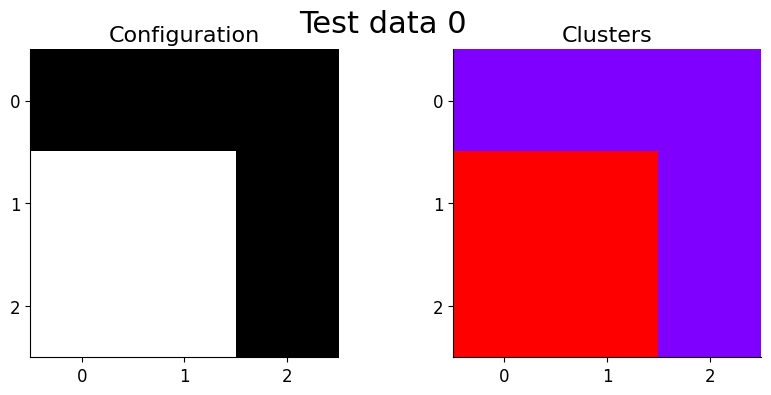

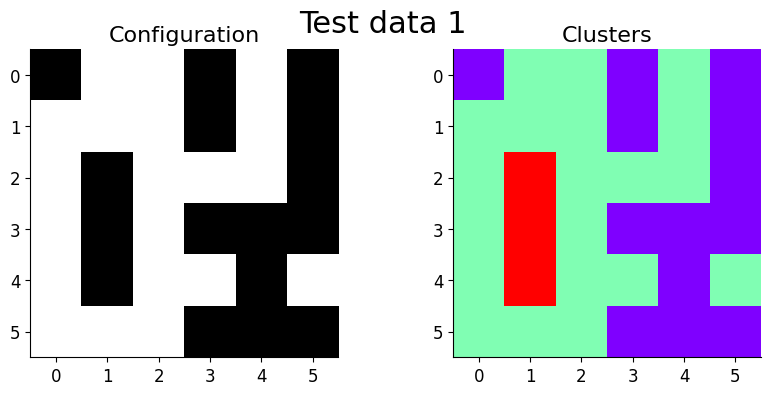

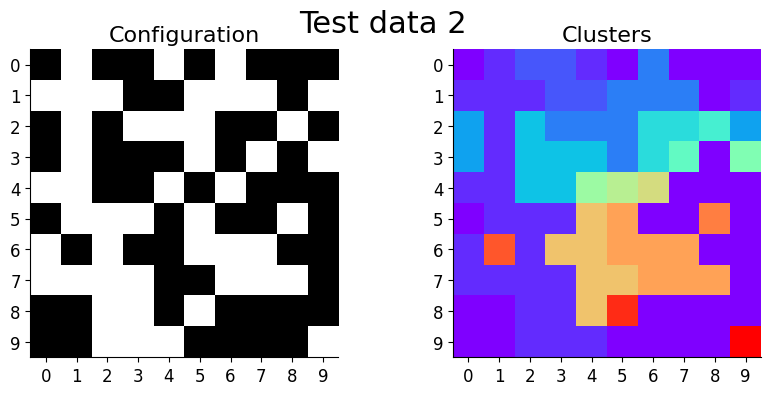

In [42]:
for i, config in enumerate([config_test_0, config_test_1, config_test_2]):
    labels = get_labels(config)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
    ax1.set_xticks(range(len(config)))
    ax1.set_yticks(range(len(config)))
    ax2.set_xticks(range(len(config)))
    ax2.set_yticks(range(len(config)))
    ax1.set_title("Configuration")
    ax2.set_title("Clusters")
    ax1.imshow(config, cmap="Greys")
    ax2.imshow(labels, cmap="rainbow")
    
    fig.suptitle(f"Test data {i}", fontsize=22)

If your function doesn't work, you might want to use this cell to inspect your results

<Axes: >

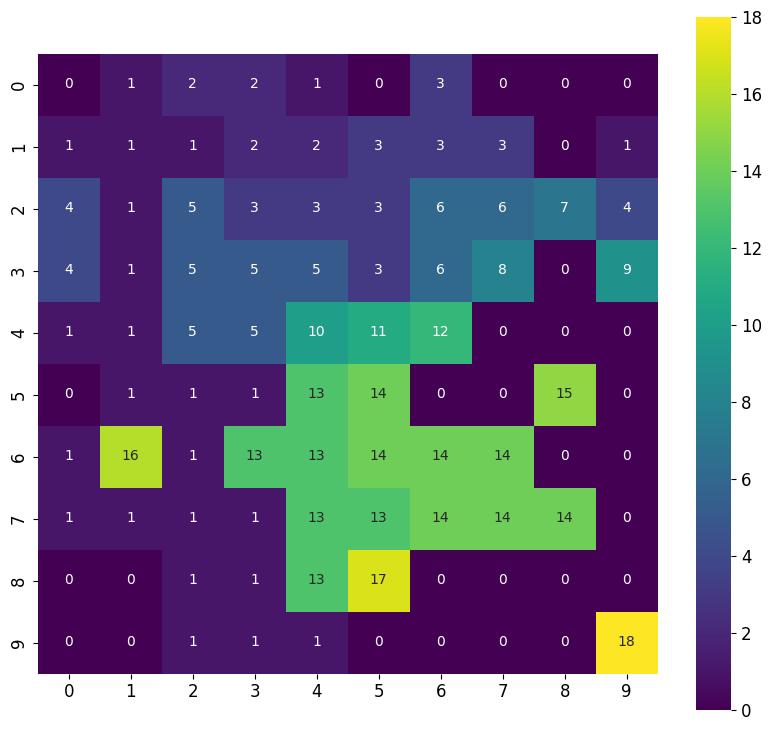

In [43]:
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(10, 9))
ax.set_aspect(1)
sns.heatmap(labels, annot=True, ax=ax, cmap="viridis")

### Measuring cluster sizes
Use your `get_labels()` function to find clusters in a large Ising model, say $N=500$. You can use your own Ising implementation. If you use Sethna's code, remember that he uses $s \in \{0, 1\}$ spins!

In [44]:
%%time
N = 500
T = T_c
model = IsingModel(N, T, H=0)

for i in range(20):
    model.SweepWolff()

labels = get_labels(model.lattice)

CPU times: user 3min 6s, sys: 298 ms, total: 3min 6s
Wall time: 3min 7s


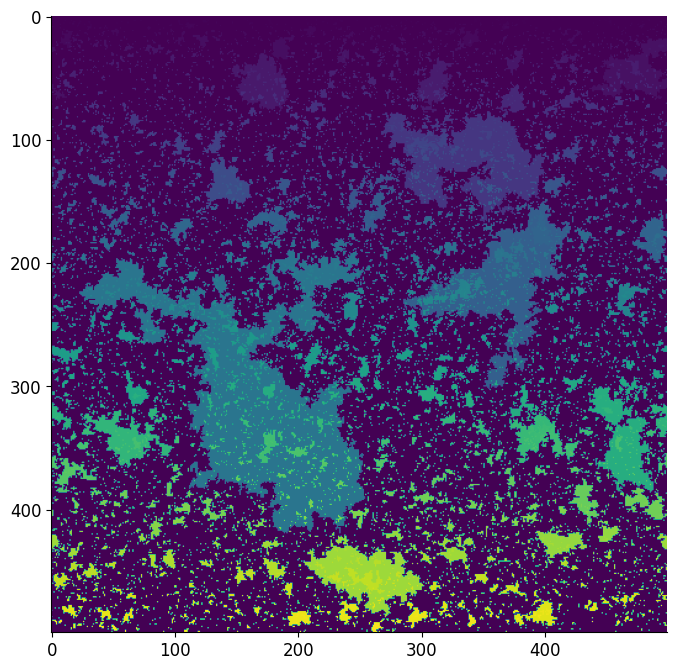

In [45]:
plt.figure(figsize=(10, 8))
plt.imshow(labels)

### Exercise 4.18
Find an efficient way to measure cluster sizes. Remind that all you care about is the distribution of cluster sizes, their location does not matter. You might want to use the `.reshape()` method of a numpy array, and the `Counter` class from the `collections` package.

In [46]:
import collections as cl

In [47]:
def get_sizes(labels):
    """
    Misura le dimensioni dei cluster di un sistema.
    
    Parametri
    ---------
    labels: np.array(N, N)
        Matrice le cui entrate contengono le etichette assegnate agli spin in base al cluster a cui appartengono.
    
    Restituisce
    -----------
    sizes: np.array(N^2)
        Array contenente le dimensioni dei cluster trovati.
    """
    #oggetto Counter (reshape() trasforma labels in un array)
    c = cl.Counter(np.reshape(labels, -1))
    #dizionario del tipo (label, ricorrenze)
    elements = c.most_common()
    #segno solo le ricorrenze
    sizes = np.array([y for x, y in elements])
    
    return sizes

### Exercise 4.19
For $T >> T_c$, spins are essentially uncorrelated. What is the distribution of cluster sizes you expect to find in this case? **Hint** Think about the 1D case assuming totally uncorrelated spins.

Nel caso 1D, consideriamo il primo spin di un cluster. Sia $p$ la probabilità (nel limite $T >> T_c$ di spin scorrelati) che uno spin successivo appartenga allo stesso cluster. La probabilità che il cluster abbia dimensione $n$ è pari alla probabilità che dopo il primo vi siano esattamente $n-1$ spin ad esso allineati:
$$
P_n = p^{n-1} (1-p)
$$
dunque la distribuzione che ci aspettiamo è esponenziale negativa. Il valore atteso di $n$ è dato dalla serie
$$
\langle n \rangle = \sum_{n=1}^{+ \infty} n P_n = \sum_{n=1}^{+ \infty} n p^{n-1} (1-p) = \frac{1}{1-p}
$$
che nel nostro caso (campo magnetico nullo) diventa $ 1/(1-1/2) = 2$, dunque ogni spin avrà mediamente due spin allineati dietro di lui, da cui segue che la dimensione media dei cluster è $2$.

Possiamo estendere intuitivamente il risultato a dimensione 2: la distribuzione resta esponenziale negativa e il valore atteso di $n$ diventa $4$ (elevato al quadrato).
